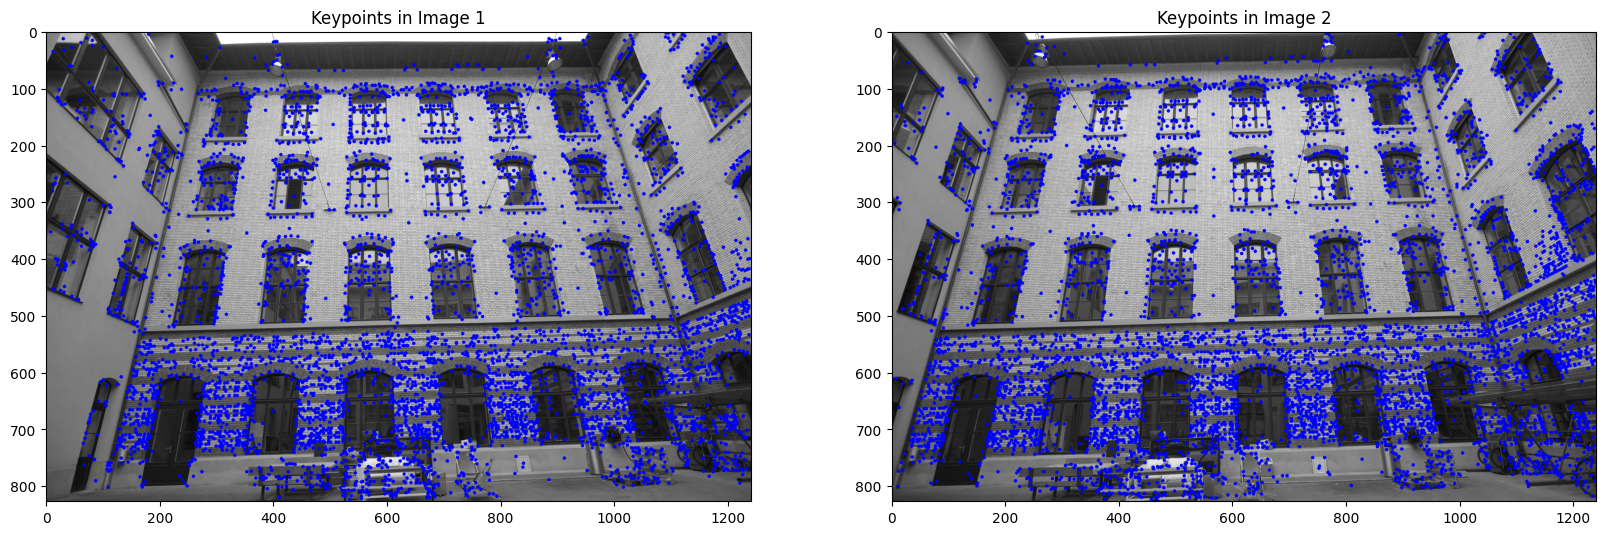

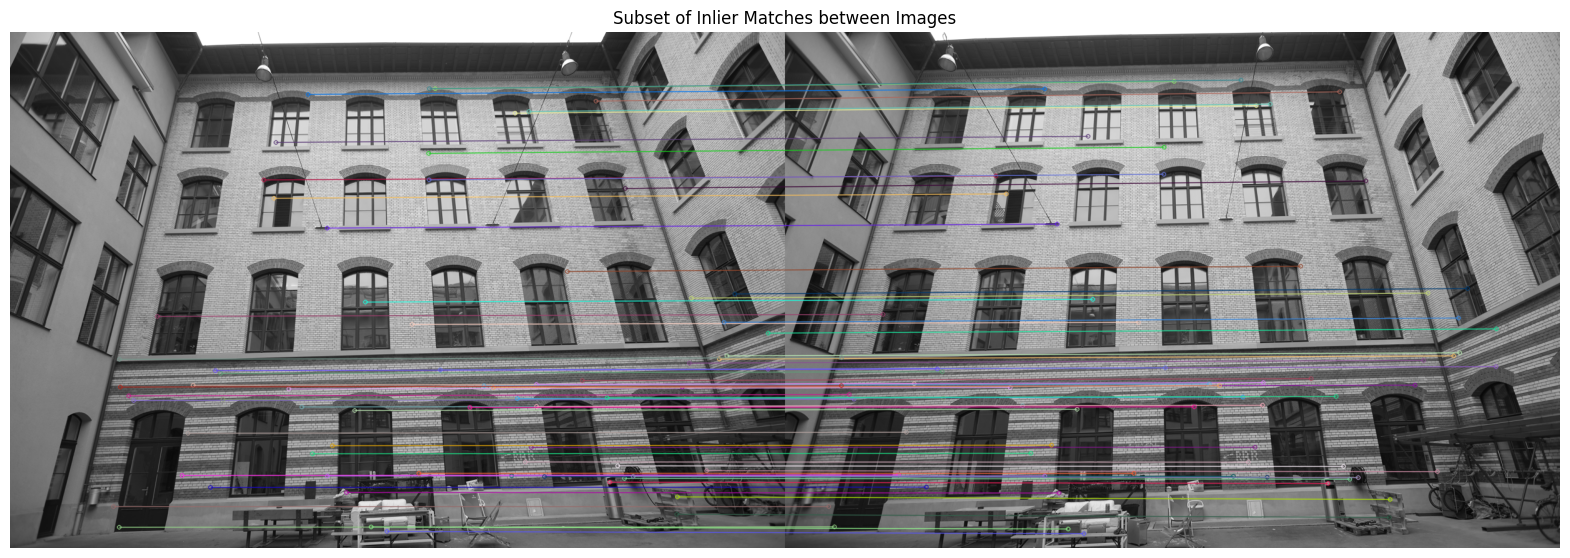

Fundamental Matrix (F):
[[-5.88152225e-07  1.78351535e-06  1.72240084e-02]
 [-2.25266480e-05 -3.16235740e-06  6.45913384e-01]
 [-4.34105101e-03 -6.41094438e-01  1.00000000e+00]]

Essential Matrix (E):
[[-2.73496332e-01  8.29317403e-01  1.19976753e+01]
 [-1.04746737e+01 -1.47040525e+00  4.29979942e+02]
 [-9.55349169e+00 -4.37287365e+02  4.91213410e+00]]


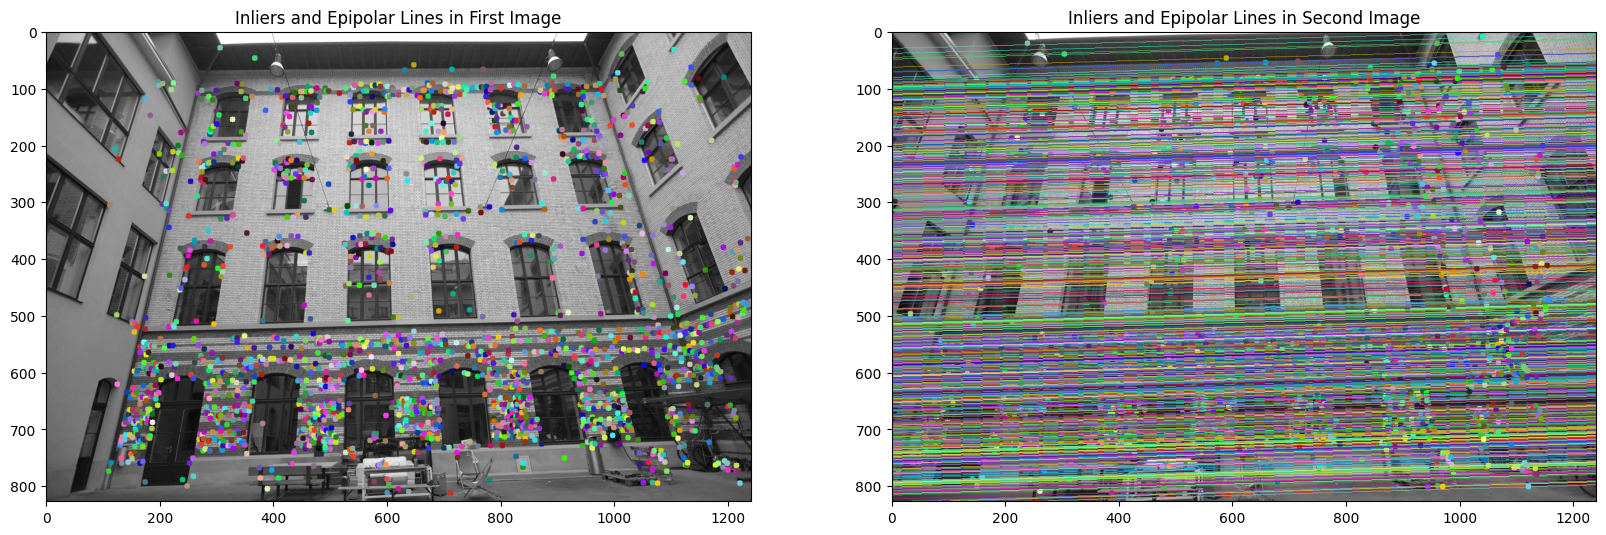

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Load images
image_path1 = '/content/I1.png'  # Replace with the path to your first image
image_path2 = '/content/I2.png'  # Replace with the path to your second image
img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

# Check if images are loaded properly
if img1 is None or img2 is None:
    print("Error: One or both images are not loaded properly. Check the file paths.")
    exit()

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Convert images to color for visualization
img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

# Draw keypoints as red points
for kp in keypoints1:
    x, y = kp.pt
    cv2.circle(img1_color, (int(x), int(y)), 3, (0, 0, 255), -1)
for kp in keypoints2:
    x, y = kp.pt
    cv2.circle(img2_color, (int(x), int(y)), 3, (0, 0, 255), -1)

# Show images with red keypoints
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img1_color)
plt.title('Keypoints in Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2_color)
plt.title('Keypoints in Image 2')
plt.show()

# Initialize the Brute-Force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Match descriptors
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract the matched keypoints
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

# Compute the Fundamental matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select only the inliers
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

# Camera intrinsic parameters matrix (replace with your actual values)
K = np.array([[681.916, 0, 623.032],
              [0, 681.888, 412.946],
              [0, 0, 1]])

# Compute the Essential matrix
E = K.T @ F @ K

# Draw only inlier matches
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

# Select a random subset of 70 inlier matches to visualize
random.shuffle(inlier_matches)
subset_size = min(70, len(inlier_matches))  # Ensure we do not exceed the number of inlier matches
subset_matches = inlier_matches[:subset_size]

# Draw the subset of matches
matched_img_subset = cv2.drawMatches(img1, keypoints1, img2, keypoints2, subset_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the image with the subset of matches
plt.figure(figsize=(20, 10))
plt.imshow(matched_img_subset)
plt.title('Subset of Inlier Matches between Images')
plt.axis('off')
plt.show()

# Print the Essential and Fundamental matrices
print("Fundamental Matrix (F):")
print(F)
print("\nEssential Matrix (E):")
print(E)

# Function to draw epipolar lines
def draw_epipolar_lines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1.shape
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 1)
        img1_color = cv2.circle(img1_color, tuple(pt1), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(pt2), 5, color, -1)
    return img1_color, img2_color

# Compute epilines for points in the second image and draw on the first image
lines1 = cv2.computeCorrespondEpilines(pts2_inliers.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img1_epilines, img2_epilines = draw_epipolar_lines(img1, img2, lines1, pts1_inliers.astype(int), pts2_inliers.astype(int))

# Compute epilines for points in the first image and draw on the second image
lines2 = cv2.computeCorrespondEpilines(pts1_inliers.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img2_epilines, img1_epilines = draw_epipolar_lines(img2, img1, lines2, pts2_inliers.astype(int), pts1_inliers.astype(int))

# Display the images with epilines
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img1_epilines)
plt.title('Inliers and Epipolar Lines in First Image')
plt.subplot(122)
plt.imshow(img2_epilines)
plt.title('Inliers and Epipolar Lines in Second Image')
plt.show()
